In [46]:
from fastai.vision.all import *

In [47]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F
import cv2

In [49]:
def get_image_paths(path, images=True) -> list:
    """Returns a list of image or masks paths from a folder"""
    paths = [path + fname for fname in os.listdir(path)]
    to_return = []
    if images:
        png_images = []
        for image in paths:
            if image.endswith(".png"):
                png_images.append(image)
        to_return = png_images
    else:
        to_return = paths
    return sorted(to_return)

This cell gets all the images from each folder and stores them in a list

In [59]:
image_folders = [
    "/content/drive/MyDrive/from_hot/1/",
    "/content/drive/MyDrive/from_hot/2/",
    "/content/drive/MyDrive/from_hot/3/",
    "/content/drive/MyDrive/from_hot/4/",
    "/content/drive/MyDrive/from_hot/5/",
]
all_images = []
for folder in image_folders:
    images = get_image_paths(folder)
    for image in images:
        all_images.append(image)

This gets all the masks from each folder and stores them in a list

In [60]:
mask_folders = [
    "/content/drive/MyDrive/rasterized_labels/1/",
    "/content/drive/MyDrive/rasterized_labels/2/",
    "/content/drive/MyDrive/rasterized_labels/3/",
    "/content/drive/MyDrive/rasterized_labels/4/",
    "/content/drive/MyDrive/rasterized_labels/5/",
]
all_masks = []
for folder in mask_folders:
    masks = get_image_paths(folder, images=False)
    for mask in masks:
        all_masks.append(mask)

In [61]:
print(len(all_images))
print(len(all_masks))

162
162


This cell checks to see if the images are sorted, and we use a visualization to ensure the image has it's corresponding mask

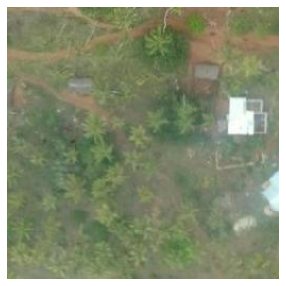

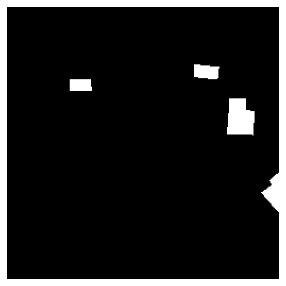

In [62]:
exampleImage = all_images[1]
exampleImage = PILImage.create(exampleImage)
exampleImage.show(figsize=(5, 5))

exampleMask = all_masks[1]
exampleMask = PILImage.create(exampleMask)
exampleMask.show(figsize=(5, 5))

We now want to divide the dataset in to 3 sub datasets: Train, Validation and Test. We will use an sklearn import to achieve this

The data will be split 80% - Train, 10% - Validation and 10% - Train

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
Xtrain, XRemaining, y_Train, yRemaining = train_test_split(
    all_images, all_masks, train_size=0.8
)

In [65]:
xValid, xTest, yValid, yTest = train_test_split(XRemaining, yRemaining, test_size=0.5)

We create paths for each specific dataset and then populate these folders

In [66]:
train_images_path = "/content/drive/MyDrive/HOT_OSM/train/images/"
train_masks_path = "/content/drive/MyDrive/HOT_OSM/train/masks/"

validation_images_path = "/content/drive/MyDrive/HOT_OSM/validation/images/"
validation_masks_path = "/content/drive/MyDrive/HOT_OSM/validation/masks/"

test_images_path = "/content/drive/MyDrive/HOT_OSM/test/images/"
test_masks_path = "/content/drive/MyDrive/HOT_OSM/test/images/"

paths = [
    train_images_path,
    train_masks_path,
    validation_images_path,
    validation_masks_path,
    test_images_path,
    test_masks_path,
]
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

In [67]:
for i in range(len(Xtrain)):
    image_path_to_save = train_images_path + str(i) + ".png"
    mask_path_to_save = train_masks_path + str(i) + ".png"
    shutil.copy2(Xtrain[i], image_path_to_save)
    shutil.copy2(y_Train[i], mask_path_to_save)

In [68]:
for i in range(len(xValid)):
    image_path_to_save = validation_images_path + str(i) + ".png"
    mask_path_to_save = validation_masks_path + str(i) + ".png"
    shutil.copy2(xValid[i], image_path_to_save)
    shutil.copy2(yValid[i], mask_path_to_save)

In [69]:
for i in range(len(xTest)):
    image_path_to_save = train_images_path + str(i) + ".png"
    mask_path_to_save = train_masks_path + str(i) + ".png"
    shutil.copy2(xTest[i], image_path_to_save)
    shutil.copy2(yTest[i], mask_path_to_save)